## Importing Libraries

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchsummary import summary
from torch.utils.data.dataset import Subset
from torch import nn

## Download and Extract the Data

In [2]:
import urllib.request
import tarfile

# Download the file if it does not exist
if not Path('transistor.tar.xz').exists():
    url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz"
    urllib.request.urlretrieve(url, 'transistor.tar.xz')

with tarfile.open('transistor.tar.xz') as f:
    f.extractall('.')

"""
Other datasets can be downloaded similarly by changing the URL.
Example URLs for other datasets (commented out):
"""
# "bottle": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz",
# "cable": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937413-1629951498/cable.tar.xz",
# "capsule": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",
# "carpet": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
# "grid": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",
# "hazelnut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",
# "leather": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",
# "metal_nut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",
# "pill": "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",
# "screw": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz",
# "tile": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938133-1629953189/tile.tar.xz",
# "toothbrush": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz",
# "transistor": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz",
# "wood": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938383-1629953354/wood.tar.xz",
# "zipper": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938385-1629953449/zipper.tar.xz"

'\nOther datasets can be downloaded similarly by changing the URL.\nExample URLs for other datasets (commented out):\n'

## Visualize some Samples

In [3]:
import matplotlib.pyplot as plt
from PIL import Image # here you can use cv2.imread/ skimage instead of PIL.Image.open

image_path = 'transistor/test/bent_lead/001.png'
image = Image.open(image_path)
print(image.size)

(1024, 1024)


torch.Size([3, 224, 224])


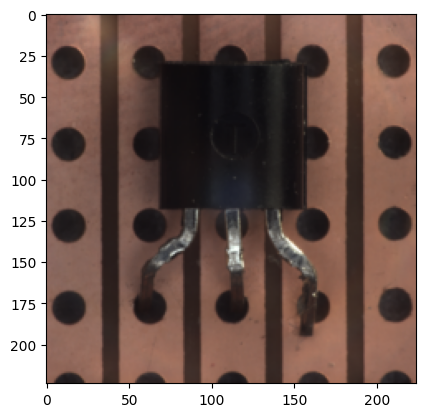

In [4]:
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor and divide by 255.0
])

# Assuming 'image' is a PIL image object
# Apply the defined transformation pipeline to the image
image = transform(image)

print(image.shape)

# Plot the transformed image
# Permute the dimensions to (height, width, channels) as matplotlib expects
plt.imshow(image.permute(1, 2, 0))
plt.show()

## Memory Consumed by the Tensor

In [ ]:
# Calculate the memory usage
memory_usage = image.numel() * image.element_size()

print(f"Memory usage of the tensor: {memory_usage * 213//1024} KB") # 213 is the number of samples we have in the dataset

In [5]:
from torchvision.datasets import ImageFolder

train_image_path = 'transistor/train'

# Load the train dataset using the ImageFolder dataset class
"""
ImageFolder is a PyTorch dataset class for loading images from a directory
--> It automatically loads images from subdirectories and applies transformations to them
--> In this case, 'transform' is a transformation applied to each image in the dataset
--> It preprocesses the images before they are used for training
"""
good_dataset = ImageFolder(root=train_image_path, transform=transform)

"""
Access a sample from the dataset
In this case, we're accessing the first sample
x contains the preprocessed image data
y contains the corresponding label (class index)
"""
x, y = good_dataset[0]

print("Image Shape:", x.shape)
print("Label:", y)

Image Shape: torch.Size([3, 224, 224])
Label: 0


## Train test split for the Autoencoder

In [6]:
import torch

# Split the dataset into training and testing subsets
"""
The `torch.utils.data.random_split` function randomly splits a dataset into non-overlapping subsets
The first argument `good_dataset` is the dataset to be split
The second argument `[0.8, 0.2]` specifies the sizes of the subsets. Here, 80% for training and 20% for testing.
"""
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])


print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))

Total number of samples in the original dataset: 213
Number of samples in the training subset: 171
Number of samples in the testing subset: 42


## Using Dataloader for efficient dataloading during training

In [7]:
import torch
from torch.utils.data import DataLoader

# Assuming train_dataset and test_dataset are PyTorch datasets containing image data and labels

# Define the batch size for training and testing
batch_size = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Get a batch of images and labels from the training loader
image_batch, label_batch = next(iter(train_loader))


print(f'Shape of input images: {image_batch.shape}')
print(f'Shape of labels: {label_batch.shape}')

# Calculate the memory usage
memory_usage = image_batch.numel() * image_batch.element_size()

print(f"Memory usage of the tensor: {memory_usage//1024} KB")

Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB


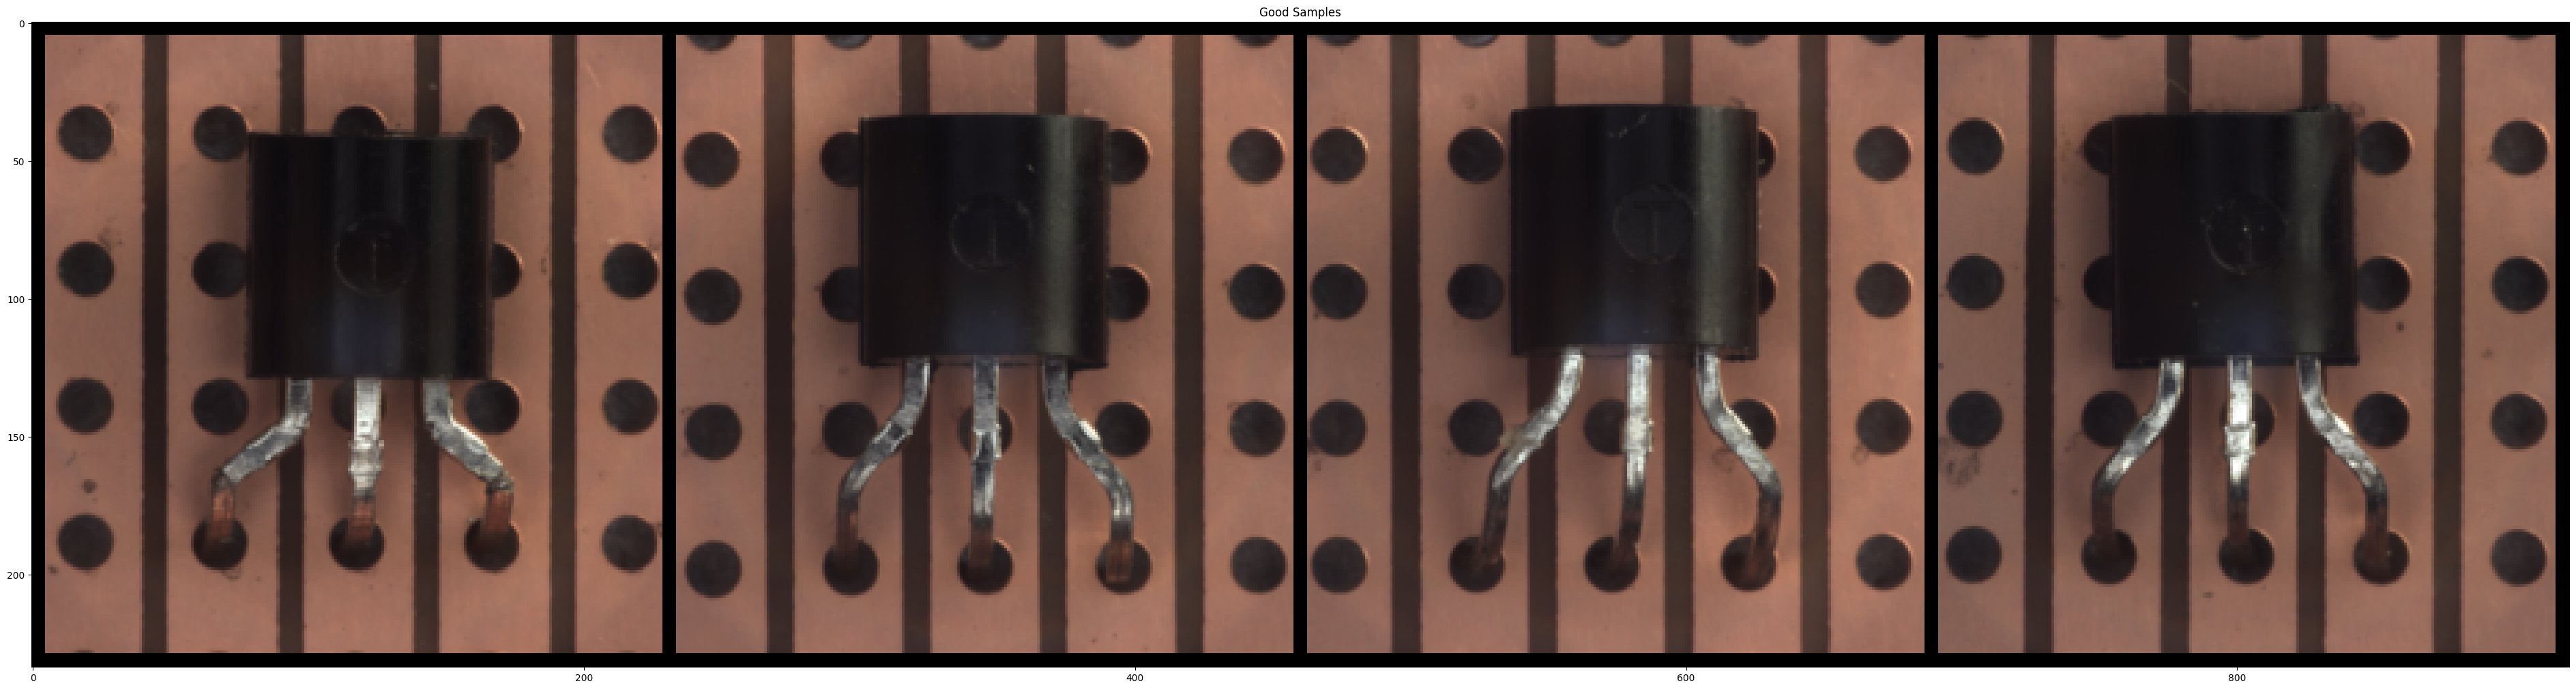

In [8]:
# Set the figure size
plt.figure(figsize=(12*4, 48*4))

# Create a grid of images from the image batch and visualize it
grid = torchvision.utils.make_grid(image_batch[0:4], padding=5, nrow=4)
plt.imshow(grid.permute(1, 2, 0))  # Permute dimensions to (height, width, channels) for visualization
plt.title('Good Samples')
plt.show()

## Train Autoencoder Model

torch.Size([3, 224, 224])


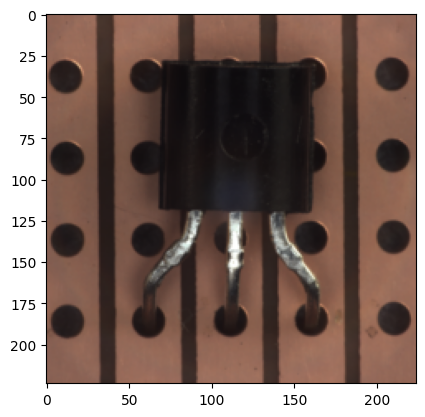

torch.Size([1, 3, 224, 224])
torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [10]:
import torch.nn.functional as F
from torch import nn


input_image = Image.open('/content/transistor/train/good/001.png')
input_image = transform(input_image)
print(input_image.shape)
plt.imshow(input_image.permute(1,2,0))
plt.show()

input_image = input_image.unsqueeze(0) # adds an extra dimension (represnting batch size)
print(input_image.shape)

# Convolutional Autoencoder Encoder (Convolutions)
c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

# Convolutional Autoencoder Decoder (Transpose Convolutions)
c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

In [11]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test the autoencoder architecture
model = Autoencoder()
input_image = torch.randn(1, 3, 224, 224)  # Sample input image
output_image = model(input_image)
print(output_image.shape)

torch.Size([1, 3, 224, 224])


In [13]:
# Define the loss function and optimizer
model.cuda() # move the model to the GPU
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

## Training Loop

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.0165, Validation Loss: 0.0139
Epoch [6/100], Loss: 0.0035, Validation Loss: 0.0038
Epoch [11/100], Loss: 0.0028, Validation Loss: 0.0027
Epoch [16/100], Loss: 0.0021, Validation Loss: 0.0021
Epoch [21/100], Loss: 0.0019, Validation Loss: 0.0020
Epoch [26/100], Loss: 0.0016, Validation Loss: 0.0018
Epoch [31/100], Loss: 0.0016, Validation Loss: 0.0016
Epoch [36/100], Loss: 0.0015, Validation Loss: 0.0015
Epoch [41/100], Loss: 0.0015, Validation Loss: 0.0016
Epoch [46/100], Loss: 0.0013, Validation Loss: 0.0014
Epoch [51/100], Loss: 0.0014, Validation Loss: 0.0014
Epoch [56/100], Loss: 0.0013, Validation Loss: 0.0013
Epoch [61/100], Loss: 0.0013, Validation Loss: 0.0013
Epoch [66/100], Loss: 0.0012, Validation Loss: 0.0013
Epoch [71/100], Loss: 0.0013, Validation Loss: 0.0013
Epoch [76/100], Loss: 0.0012, Validation Loss: 0.0012
Epoch [81/100], Loss: 0.0012, Validation Loss: 0.0012
Epoch [86/100], Loss: 0.0012, Validation Loss: 0.0012
Epoch [91/100], Loss: 0.0011, 

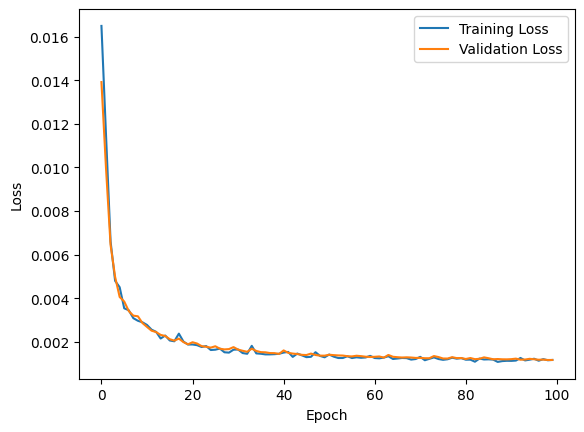

In [14]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    for img, _ in train_loader:
        img = img.cuda()

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() # This line clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients.
    Loss.append(loss.item())


    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in test_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Save the model
torch.save(model.state_dict(), 'simple_autoencoder_l2_loss.pth')
model.eval()

ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
model.load_state_dict(ckpoints)

<All keys matched successfully>

## Reconstruction of Good Images

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

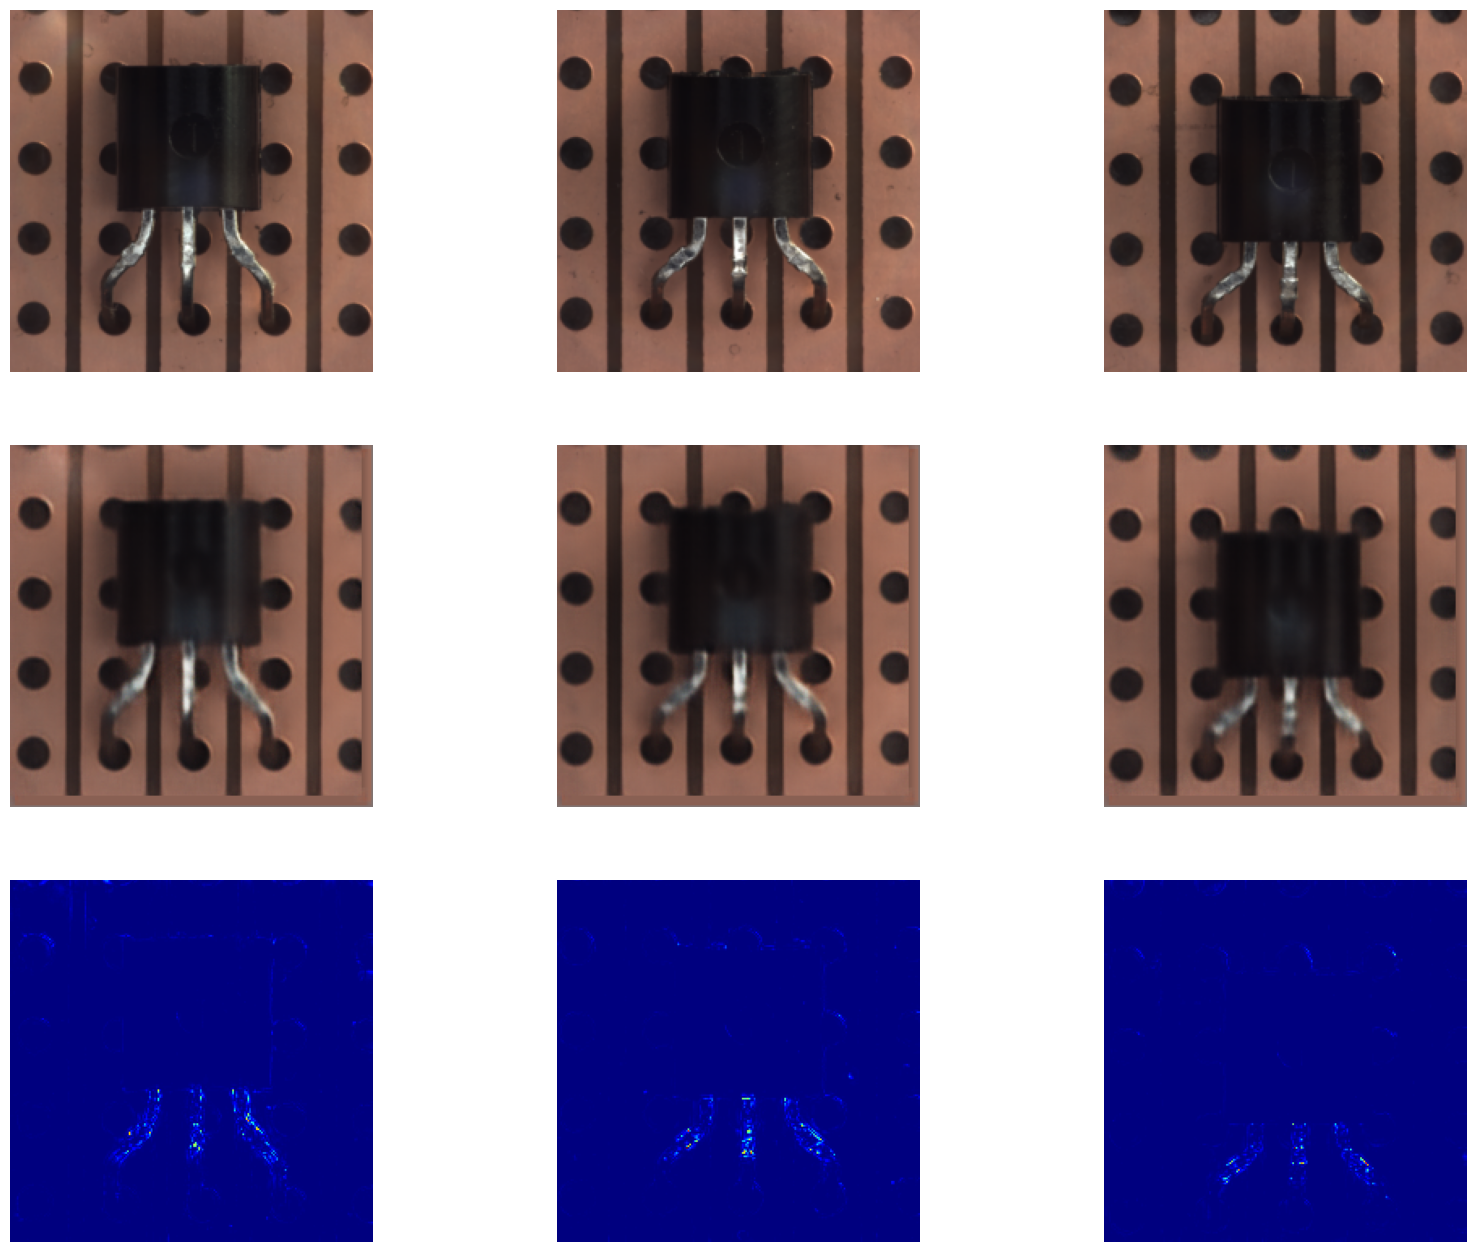

In [16]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

## Reconstruction of Bad Images

Obtain the fault detection HEATMAP using AE

<Figure size 1600x1200 with 0 Axes>

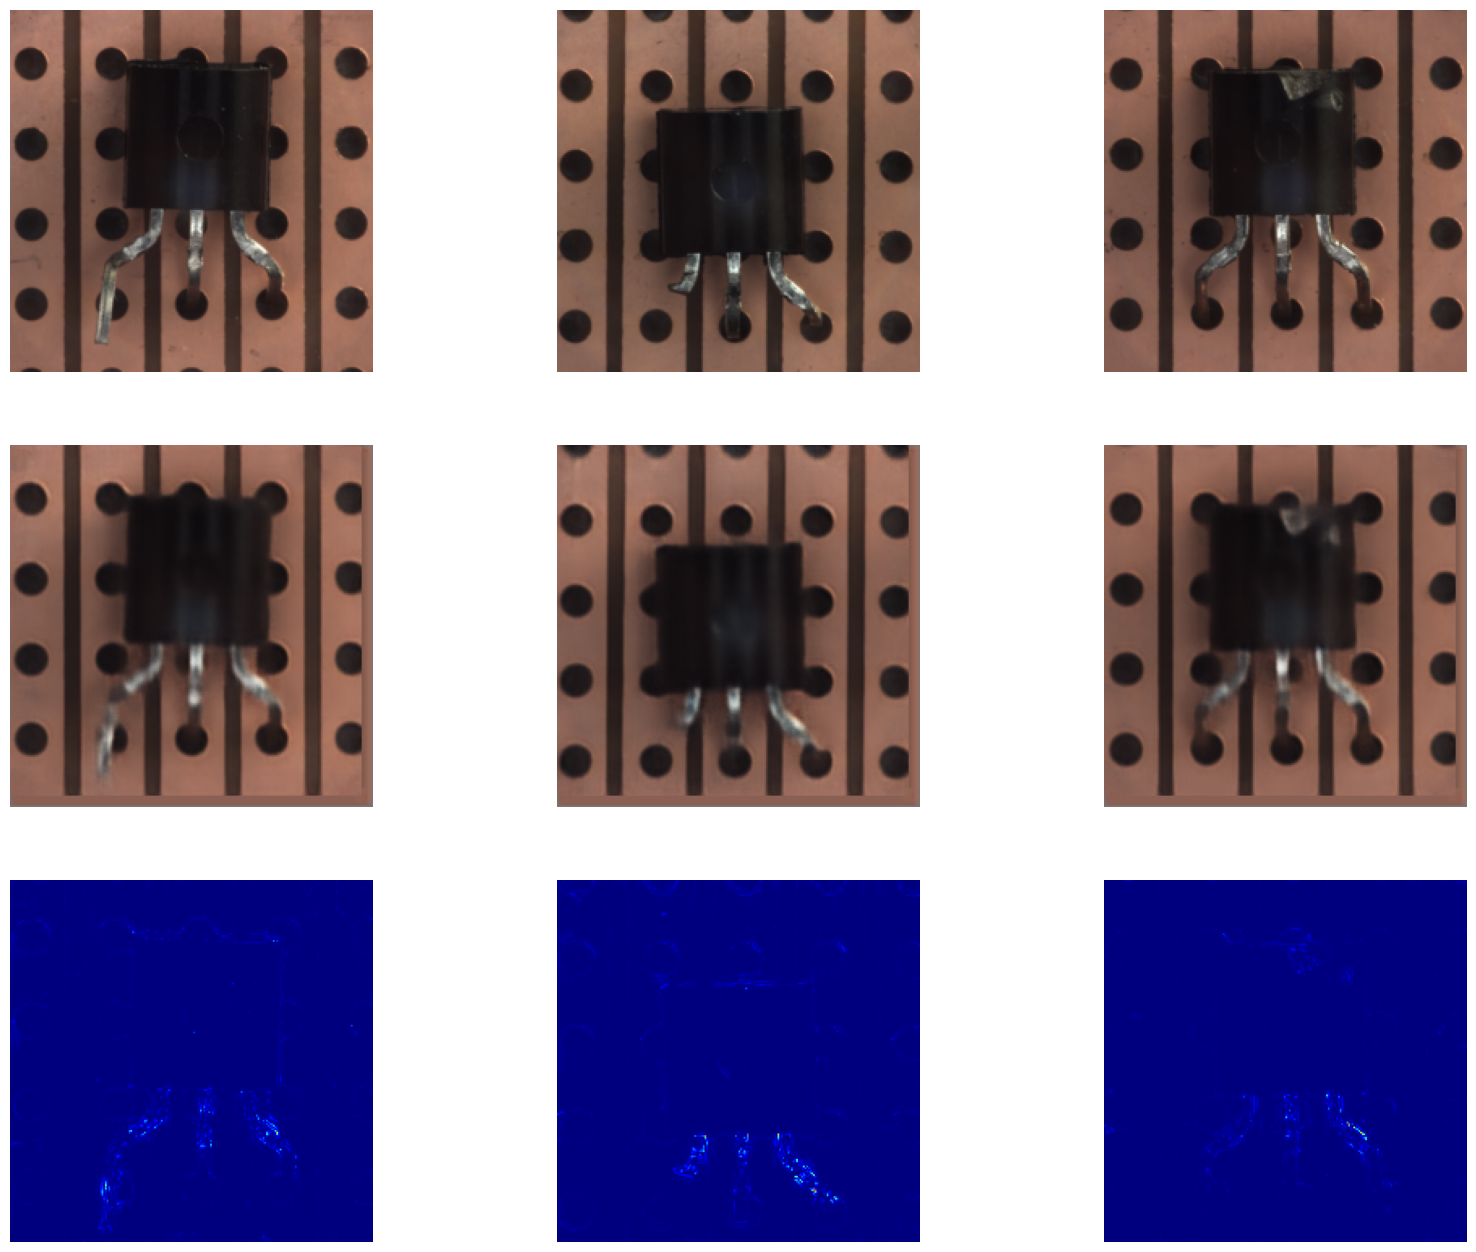

In [18]:
test_image_1 = transform(Image.open('/content/transistor/test/bent_lead/000.png'))
test_image_2 = transform(Image.open('/content/transistor/test/cut_lead/000.png'))
test_image_3 = transform(Image.open('/content/transistor/test/damaged_case/000.png'))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)

recon_error =  ((data-recon)**2).mean(axis=1)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

## Obtain the fault detection accuracy

In [19]:
RECON_ERROR=[]
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        data_recon_squared_mean =  ((data-recon)**2).mean(axis=(1))[:,0:-10,0:-10].mean(axis=(1,2))

        RECON_ERROR.append(data_recon_squared_mean)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

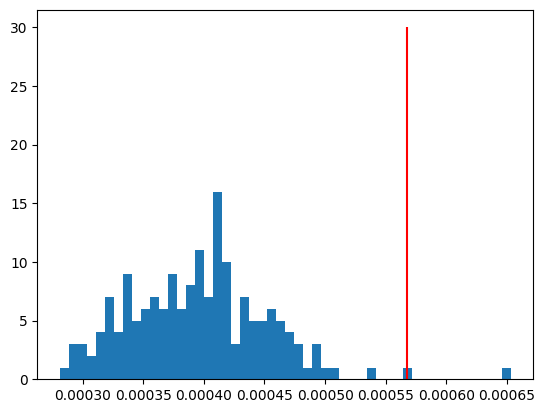

In [20]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [24]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()

with torch.no_grad():

    test_path = Path('transistor/test')

    for path in test_path.glob('*/*.png'):
        fault_type = path.parts[-2]
        # if fault_type != 'good':
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        recon_image = model(test_image)

        # y_score_image =
        y_score_image =  ((test_image - recon_image)**2).mean(axis=(1))[:,0:-10,0:-10].mean()

        y_pred_image = 1*(y_score_image >= best_threshold)

        y_true_image = 0 if fault_type == 'good' else 1

        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

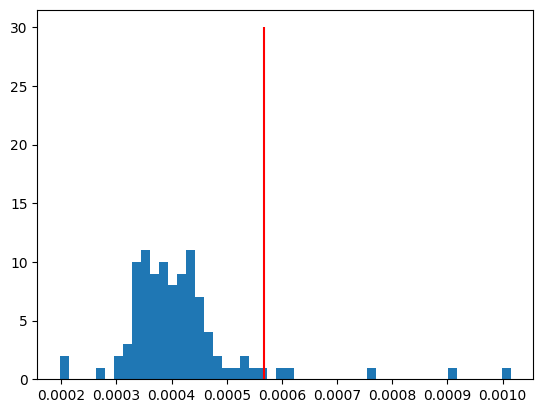

In [25]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

## ROC Curve

AUC-ROC Score: 0.5566666666666666


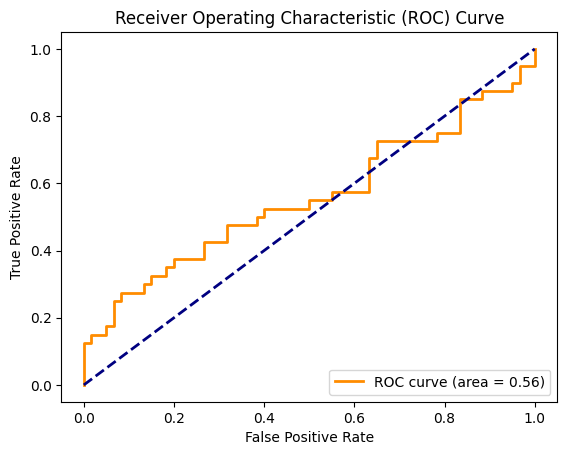

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns

# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()